# Midterm

## Options

In [100]:
train_SRGAN = True
continueTraining_SRGAN = True

## Imports

In [2]:
import numpy as np
from tensorflow import keras
import tensorflow as tf
import os
import datetime
import shutil
import re
import time
#from tqdm import tqdm

logs_base_dir = "./logs"
shutil.rmtree(logs_base_dir, ignore_errors=True)
os.makedirs(logs_base_dir, exist_ok=True)

gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu,True)
    except RuntimeError as e:
        print(e)

%load_ext tensorboard

In [3]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 10047550494415935634
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 6721363968
locality {
  bus_id: 1
  links {
  }
}
incarnation: 10157509835513654503
physical_device_desc: "device: 0, name: NVIDIA GeForce GTX 1080, pci bus id: 0000:0a:00.0, compute capability: 6.1"
]


### Separating the data

In [49]:
label_list = []
cats = [0 for i in range(12500)]
dogs = [1 for i in range(12500)]
label_list.extend(cats)
label_list.extend(dogs)

In [50]:

ds = keras.utils.image_dataset_from_directory(
    directory='data/dogs_cats/train/',
    labels=label_list,
    label_mode=None,
    batch_size=64,
    image_size=(256,256),
    seed=0,
)
(train_ds) = ds

Found 25000 files belonging to 1 classes.


### Preprocess and Augment the data

In [51]:
data_augmentation = keras.Sequential(
    [
        keras.layers.RandomFlip("horizontal"),
        keras.layers.RandomRotation(0.1),
        keras.layers.RandomFlip("vertical"),
        keras.layers.RandomZoom(height_factor=0.1,width_factor=0.1)
    ]
)

## Step 2: Training SRGAN

In [12]:
def GENBlock(x):
    out = keras.layers.Conv2D(64, (3,3), (1,1), padding='same')(x)
    out = keras.layers.BatchNormalization()(out)
    out = keras.layers.PReLU()(out)
    out = keras.layers.Conv2D(64, (3,3), (1,1), padding='same')(x)
    out = keras.layers.BatchNormalization()(out)
    out = keras.layers.Add()([out, x])
    return out

def DISBlock(x, n):
    out = keras.layers.Conv2D(n, (3,3), (1,1), padding='same')(x)
    out = keras.layers.BatchNormalization()(out)
    out = keras.layers.LeakyReLU(0.2)(out)
    out = keras.layers.Conv2D(n, (3,3), (2,2), padding='same')(x)
    out = keras.layers.BatchNormalization()(out)
    out = keras.layers.LeakyReLU(0.2)(out)
    return out


### Helper Function

In [13]:
import matplotlib.pyplot as plt
from IPython import display

def generate_and_save_images(model, epoch, test_input, gt_output):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(4, 3))

  for i in range(12):
      plt.subplot(4, 3, i+1)
      if i % 3 == 0:
         plt.imshow(tf.cast(tf.clip_by_value(predictions[i // 3, :, :, :], 0, 255), "uint8"))
      elif i % 3 == 1:
         plt.imshow(tf.cast(tf.clip_by_value(test_input[i // 3], 0, 255), "uint8")) 
      else:
         plt.imshow(tf.cast(tf.clip_by_value(gt_output[i // 3], 0, 255), "uint8"))
      
      if i == 0:
         plt.title("Generated")
      elif i == 1:
         plt.title("Resized")
      elif i == 2:
         plt.title("Original")
      plt.axis('off')

  plt.savefig('training_outputs/image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()
  plt.close()

### Generator 64x64 to 256x256

In [28]:
inputs = keras.Input(shape=(64,64,3))
scaled_layer = keras.layers.Rescaling(scale=1/255.0, offset=0)

x = scaled_layer(inputs)
x = keras.layers.Conv2D(64, (9,9), (1,1), padding='same')(x)
x = keras.layers.PReLU()(x)
x_skip = x
for i in range(5):
    x = GENBlock(x)
x = keras.layers.Conv2D(64, (3,3), (1,1), padding='same')(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Add()([x, x_skip])

x = keras.layers.Conv2D(256, (3,3), (1,1), padding='same')(x)
x = keras.layers.Reshape((x.shape[1]*2, x.shape[2]*2, x.shape[3]//4))(x)
x = keras.layers.PReLU()(x)

x = keras.layers.Conv2D(256, (3,3), (1,1), padding='same')(x)
x = keras.layers.Reshape((x.shape[1]*2, x.shape[2]*2, x.shape[3]//4))(x)
x = keras.layers.PReLU()(x)

outputs = keras.layers.Conv2D(3, (9,9), (1,1), padding='same')(x)

generator_model = keras.Model(inputs, outputs)
generator_model.summary()

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            [(None, 64, 64, 3)]  0                                            
__________________________________________________________________________________________________
rescaling_5 (Rescaling)         (None, 64, 64, 3)    0           input_9[0][0]                    
__________________________________________________________________________________________________
conv2d_54 (Conv2D)              (None, 64, 64, 64)   15616       rescaling_5[0][0]                
__________________________________________________________________________________________________
p_re_lu_16 (PReLU)              (None, 64, 64, 64)   262144      conv2d_54[0][0]                  
____________________________________________________________________________________________

### Discriminator

In [19]:
inputs = keras.Input(shape=(256,256,3))
scaled_layer = keras.layers.Rescaling(scale=1/255.0, offset=0)

x = scaled_layer(inputs)
x = keras.layers.Conv2D(64, (3,3), (1,1), padding='same')(x)
x = keras.layers.LeakyReLU(0.2)(x)
x = keras.layers.Conv2D(64, (3,3), (2,2), padding='same')(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.LeakyReLU(0.2)(x)
x = DISBlock(x, 128)
x = DISBlock(x, 256)
x = DISBlock(x, 512)
x = keras.layers.Flatten()(x)
x = keras.layers.Dense(1024)(x)
x = keras.layers.LeakyReLU(0.2)(x)
x = keras.layers.Dense(1)(x)

outputs = keras.activations.sigmoid(x)
outputs = x

discriminator_model = keras.Model(inputs, outputs)
discriminator_model.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
rescaling_3 (Rescaling)      (None, 256, 256, 3)       0         
_________________________________________________________________
conv2d_31 (Conv2D)           (None, 256, 256, 64)      1792      
_________________________________________________________________
leaky_re_lu_18 (LeakyReLU)   (None, 256, 256, 64)      0         
_________________________________________________________________
conv2d_32 (Conv2D)           (None, 128, 128, 64)      36928     
_________________________________________________________________
batch_normalization_25 (Batc (None, 128, 128, 64)      256       
_________________________________________________________________
leaky_re_lu_19 (LeakyReLU)   (None, 128, 128, 64)      0   

### Training

In [101]:
if train_SRGAN and continueTraining_SRGAN:
    generator_model.load_weights("models/gen_model.ckpt")
    discriminator_model.load_weights("models/dis_model.ckpt")

In [102]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=False)
mse_loss = tf.keras.losses.MeanSquaredError()

vgg_model = keras.applications.VGG19(
    weights="imagenet",
    input_shape=(256,256,3),
    include_top=False
)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [103]:
@tf.function
def train_step(small_image, big_image):
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator_model(small_image, training=True)

        real_output = discriminator_model(big_image, training=True)
        fake_output = discriminator_model(generated_images, training=True)

        disc_loss = discriminator_loss(real_output, fake_output)

        g_loss = generator_loss(fake_output)
        m_loss = mse_loss(big_image, generated_images)
        v_loss = mse_loss(vgg_model(big_image), vgg_model(generated_images))
        gen_loss = g_loss + m_loss + v_loss

        grad_gen = gen_tape.gradient(gen_loss, generator_model.trainable_variables)
        grad_disc = disc_tape.gradient(disc_loss, discriminator_model.trainable_variables)

        generator_optimizer.apply_gradients(zip(grad_gen, generator_model.trainable_variables))
        discriminator_optimizer.apply_gradients(zip(grad_disc, discriminator_model.trainable_variables))

def train(big_dataset, epochs):
    resize_layer = keras.layers.Resizing(64, 64)
    for epoch in(range(epochs)):
        start = time.time()
        for big_batch in big_dataset:
            big = np.expand_dims(big_batch[0], axis=0)
            small_batch = resize_layer(big)
    
            #print(small_batch.shape)
            #print("expand")
            #small_batch = np.expand_dims(small_batch, axis=0)
            #print(small_batch.shape)
            #print(big_batch[0].shape)
            
            #print(big.shape)
            
            train_step(small_batch, big)

        iterator_big = iter(big_dataset)
        big_batch = iterator_big.get_next()
        small_batch = resize_layer(big_batch)
        small_batch = small_batch[0:4]
        #small_batch = np.expand_dims(small_batch, axis=0)
        
        #print("Big batch")
        #print(big_batch.shape)
        #print(big_batch[0].shape)
        #print("Small batch")
        #print(small_batch.shape)
        
        
        
        #big = np.expand_dims(big_batch[0], axis=0)
        
        
        generate_and_save_images(generator_model, epoch, small_batch, big_batch)
        print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

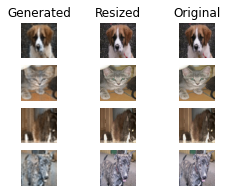

Time for epoch 1 is 57.91162657737732 sec


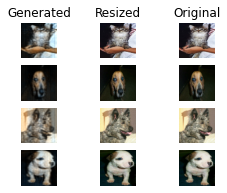

Time for epoch 2 is 48.11767649650574 sec


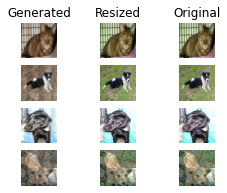

Time for epoch 3 is 47.91561198234558 sec


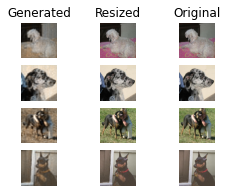

Time for epoch 4 is 48.3085253238678 sec


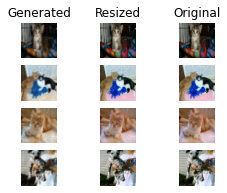

Time for epoch 5 is 47.93464136123657 sec


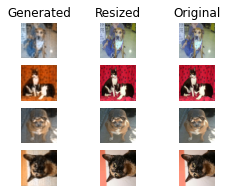

Time for epoch 6 is 48.03889489173889 sec


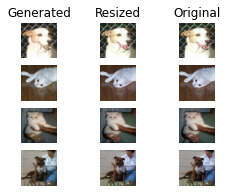

Time for epoch 7 is 48.183462619781494 sec


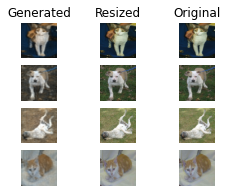

Time for epoch 8 is 48.14788246154785 sec


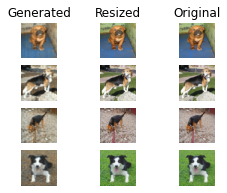

Time for epoch 9 is 48.45459318161011 sec


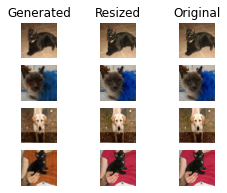

Time for epoch 10 is 48.07160973548889 sec


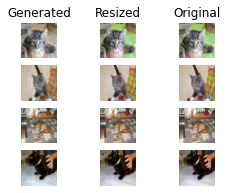

Time for epoch 11 is 48.12897229194641 sec


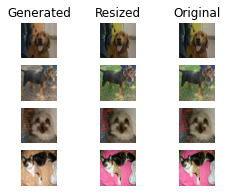

Time for epoch 12 is 48.3529326915741 sec


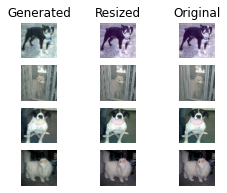

Time for epoch 13 is 48.08080077171326 sec


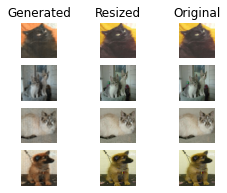

Time for epoch 14 is 48.245452642440796 sec


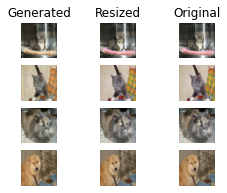

Time for epoch 15 is 47.58133625984192 sec


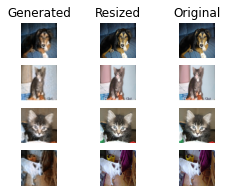

Time for epoch 16 is 47.53161263465881 sec


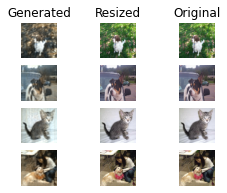

Time for epoch 17 is 48.14871835708618 sec


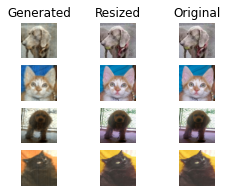

Time for epoch 18 is 48.10653471946716 sec


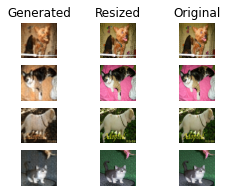

Time for epoch 19 is 48.49845480918884 sec


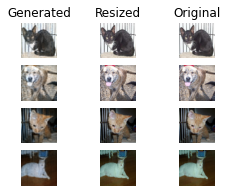

Time for epoch 20 is 48.13378882408142 sec


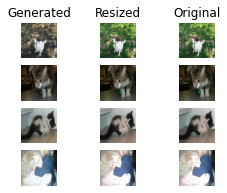

Time for epoch 21 is 48.04832887649536 sec


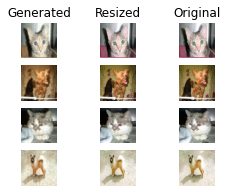

Time for epoch 22 is 48.42069458961487 sec


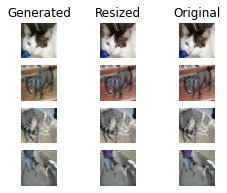

Time for epoch 23 is 47.930917739868164 sec


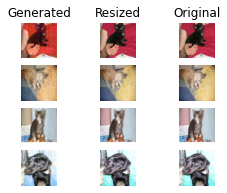

Time for epoch 24 is 48.25744843482971 sec


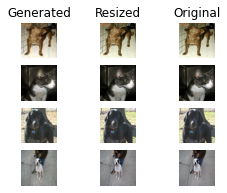

Time for epoch 25 is 48.02872109413147 sec


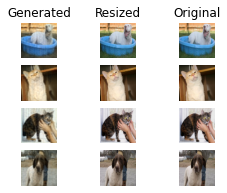

Time for epoch 26 is 48.172879695892334 sec


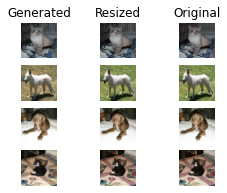

Time for epoch 27 is 48.38083744049072 sec


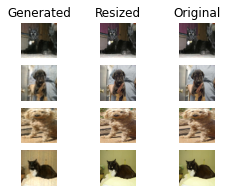

Time for epoch 28 is 48.04817533493042 sec


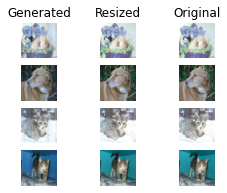

Time for epoch 29 is 48.21143102645874 sec


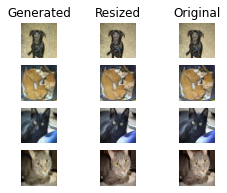

Time for epoch 30 is 47.65730571746826 sec


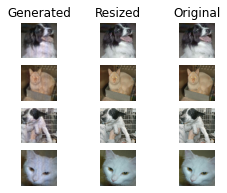

Time for epoch 31 is 47.36825942993164 sec


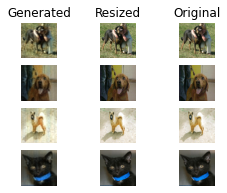

Time for epoch 32 is 47.514429569244385 sec


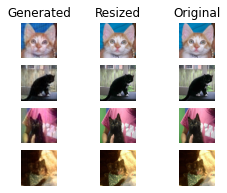

Time for epoch 33 is 47.45113801956177 sec


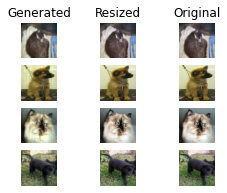

Time for epoch 34 is 47.38542604446411 sec


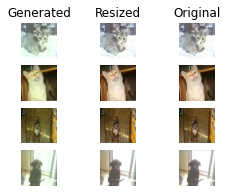

Time for epoch 35 is 47.64726114273071 sec


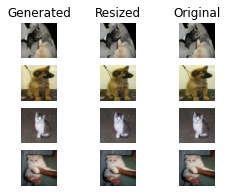

Time for epoch 36 is 47.394652366638184 sec


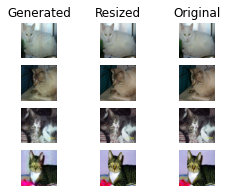

Time for epoch 37 is 47.76421546936035 sec


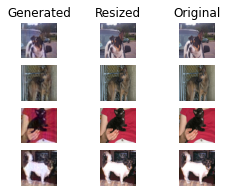

Time for epoch 38 is 47.39846849441528 sec


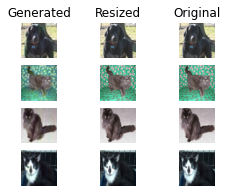

Time for epoch 39 is 47.34336757659912 sec


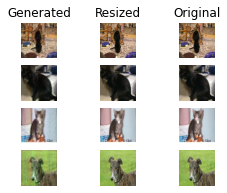

Time for epoch 40 is 54.146270751953125 sec


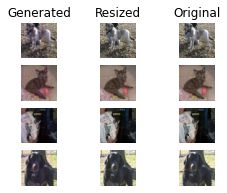

Time for epoch 41 is 62.74320340156555 sec


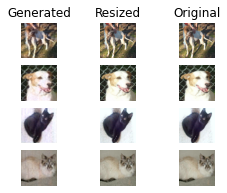

Time for epoch 42 is 48.38199996948242 sec


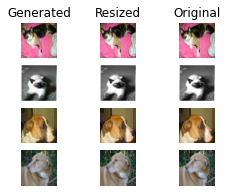

Time for epoch 43 is 47.920971155166626 sec


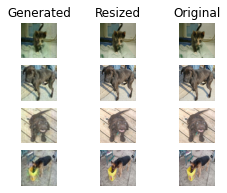

Time for epoch 44 is 48.363566875457764 sec


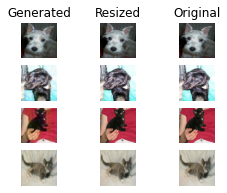

Time for epoch 45 is 47.856666564941406 sec


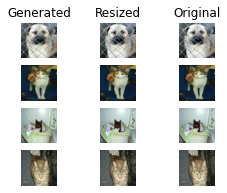

Time for epoch 46 is 47.98354625701904 sec


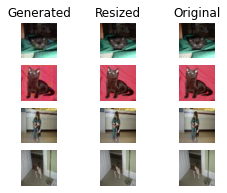

Time for epoch 47 is 48.26800751686096 sec


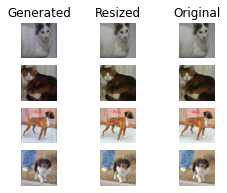

Time for epoch 48 is 48.07605218887329 sec


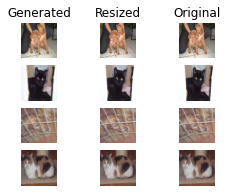

Time for epoch 49 is 48.39732766151428 sec


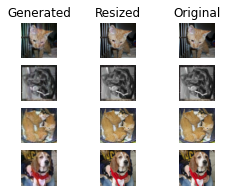

Time for epoch 50 is 47.921175956726074 sec


In [104]:
if train_SRGAN:
    train(train_ds, 50)

In [99]:
if train_SRGAN:
    generator_model.save_weights("models/gen_model.ckpt")
    discriminator_model.save_weights("models/dis_model.ckpt")
else:
    generator_model.load_weights("models/gen_model.ckpt")
    discriminator_model.load_weights("models/dis_model.ckpt")

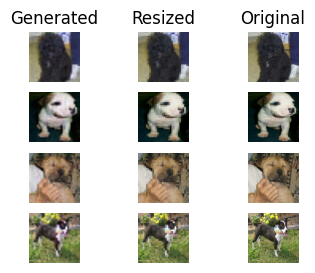

In [20]:
resize_layer = tf.keras.layers.Resizing(128, 128)
iterator = iter(train_ds)
big_dataset = iterator.get_next()
small_dataset = resize_layer(big_dataset)
small_batch = small_batch[0:4]

generate_and_save_images(generator_model, 9999, small_dataset, big_dataset)